In [36]:

import os
%cd /home/gaen/Documents/codespace-gaen/Ts-master
# Get the current directory
current_directory = os.getcwd()

# List all files and folders in the current directory
files_and_folders = os.listdir(current_directory)
print(current_directory)

/home/gaen/Documents/codespace-gaen/Ts-master
/home/gaen/Documents/codespace-gaen/Ts-master


In [37]:
import os, torch, pandas as pd, numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules import TransformerEncoder, TransformerEncoderLayer, LayerNorm
from torch import nn
import pytorch_spiking
import matplotlib.pyplot as plt
import random
import pickle

In [38]:
#from google.colab import drive
#drive.mount('{current_directory}/backtest/{load_model_name}/drive')

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

load_model_name = 'LSTM_long150000'
lenth_of_orderbook = 150000
%cd {current_directory}/backtest
load_orderbook_name = '4000longshot'
# model_file_name_struct = 'transformer_enclinear_forecasting_FINAL_horizon_'
model_file_name_struct = 'LSTM_MO_LAG_'
save_path = f'{current_directory}/backtest/{load_model_name}'
os.makedirs(save_path, exist_ok=True)
#os.makedirs(filepath, exist_ok=True)
%cd {current_directory}
#Note: if running cuda need to modify pytorch_spiking function's source code directly

/home/gaen/Documents/codespace-gaen/Ts-master/backtest
/home/gaen/Documents/codespace-gaen/Ts-master


## Models

In [40]:
class TimeSeriesDataset(Dataset):
    '''
    Class for converting FTS data into time series for the ML models.
    '''
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

def prepare_data_x(data, window_size, lag):
    '''
    Windows the input data for the ML models.
    '''
    subset = data[:window_size]
    subset_mean = np.mean(subset, axis=0)
    output = np.zeros([1, window_size, len(subset_mean)])
    x_mean = np.zeros([1, len(subset_mean)])
    x_std = np.zeros([1, len(subset_mean)])
    for idx in range(1):
        subset = data[idx:idx+window_size]
        subset_mean = np.mean(subset, axis=0)
        subset_std = np.std(subset, axis=0) + 0.01
        subset_norm = (subset-subset_mean)/subset_std
        x_mean[idx,:] = subset_mean
        x_std[idx,:] = subset_std
        output[idx,:,:] = subset_norm
    return output

def prepare_data_y(x, window_size, lag, delay):
    '''
    Windows the target data for the ML models.
    '''
    output = np.zeros([1,1,1])
    x = x.values
    std = 1.1*np.sqrt(lag)+lag*0.01
    future_price = x[window_size+lag-1,0]
    future_ask = x[window_size+lag-1,20]
    future_bid = x[window_size+lag-1,2]
    current_price = x[window_size+delay-1, 0]
    delayed_ask = x[window_size+delay-1, 20]
    delayed_bid = x[window_size+delay-1, 2]
    logreturn = np.log(future_price/current_price)*10_000
    output[0,0,0] = logreturn
    return output, current_price, future_price, delayed_bid, delayed_ask, future_bid, future_ask

def prepare_data(normalized_prices_train, delay, lag=1):
    '''
    Returns input and target data.
    '''
    data_x = prepare_data_x(normalized_prices_train, window_size=100, lag=lag)
    data_y, current_price, future_price, delayed_bid, delayed_ask, future_bid, future_ask = prepare_data_y(normalized_prices_train, window_size=100, lag=lag, delay=delay)
    return data_x, data_y, current_price, future_price, delayed_bid, delayed_ask, future_bid, future_ask


In [41]:
class HFformer(nn.Module):
    '''
    The HFformer model.
    '''
    def __init__(self, n_time_series, seq_len, output_seq_len, d_model=128, n_heads=8,
                 n_layers_encoder=6, dropout=0.1, output_dim=1, forward_dim=2048, use_mask=False):
        super(HFformer, self).__init__()
        self.n_time_series = n_time_series
        self.d_model = d_model
        self.nheads = n_heads
        self.forward_dim = forward_dim
        self.dropout = dropout
        self.n_layers_encoder = n_layers_encoder
        self.output_dim = output_dim 
        self.seq_len = seq_len
        self.output_seq_len = output_seq_len
        self.mask_it = use_mask

        self.dense_shape = nn.Linear(self.n_time_series, self.d_model)
        self.encoder_layer = TransformerEncoderLayer(self.d_model, self.nheads, self.forward_dim, self.dropout, activation=pytorch_spiking.SpikingActivation(nn.PReLU()))
        self.encoder_norm = LayerNorm(self.d_model)
        self.transformer_enc = TransformerEncoder(self.encoder_layer, self.n_layers_encoder, self.encoder_norm)
        self.output_dim_layer = nn.Linear(self.d_model, self.output_dim)
        self.out_length_lay = nn.Linear(self.seq_len, self.output_seq_len)
        self.mask = generate_square_subsequent_mask(self.seq_len).to(device)
        self.activation = nn.PReLU()
    
    def make_embedding(self, x):
        x = self.dense_shape(x)
        x = x.permute(1, 0, 2)
        if self.mask_it:
            x = self.transformer_enc(x, self.mask)
        else:
            x = self.transformer_enc(x)
        return x


    def forward(self, x):
        x = self.dense_shape(x)
        x = x.permute(1, 0, 2)
        if self.mask_it:
            x = self.transformer_enc(x, self.mask)
        else:
            x = self.transformer_enc(x)
        x = self.output_dim_layer(x)
        x = x.permute(1, 2, 0)
        x = self.activation(x)
        x = self.out_length_lay(x)
        if self.output_dim > 1:
            return x.permute(0, 2, 1)
        return x.view(-1, self.output_seq_len)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


class LSTM_MO(nn.Module):
    '''
    The many-to-one LSTM model.
    '''
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.prelu = nn.PReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()


    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)


    def forward(self, x):
        batchsize = x.shape[0]
        x = self.linear_1(x)
        x = self.prelu(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]


## Loading Data

In [42]:
def augment_trade_data(df, lag, forecast_window=None):
    '''
    Augmenting input data.
    '''
    if forecast_window:
        df['lag_return'] = np.log(df['price'].shift(forecast_window)/df['price'].shift(forecast_window+1))
        return df.iloc[forecast_window+1:,:]
    if lag == 0:
        return df
    else:
        col_name = 'log_lag'+str(lag)+'_price'
        df[col_name] = np.log(df.price) - np.log(df.price).shift(lag)
        return df.iloc[lag:,:]

In [43]:
orderbook = pd.read_csv(f'{current_directory}/input_data/{load_orderbook_name}/orderbook_agg_trade_dollarvol_{lenth_of_orderbook}.csv')
#orderbook['price'] = orderbook['w_midprice']

(132676, 43)
100000    2024-09-04 19:23:24.988
100001    2024-09-04 19:23:50.912
100002    2024-09-04 19:24:21.134
100003    2024-09-04 19:24:59.450
100004    2024-09-04 19:25:23.497
                   ...           
132671    2024-09-07 23:57:47.481
132672    2024-09-07 23:58:18.310
132673    2024-09-07 23:58:45.868
132674    2024-09-07 23:58:59.751
132675    2024-09-07 23:59:12.384
Name: datetime, Length: 32676, dtype: object


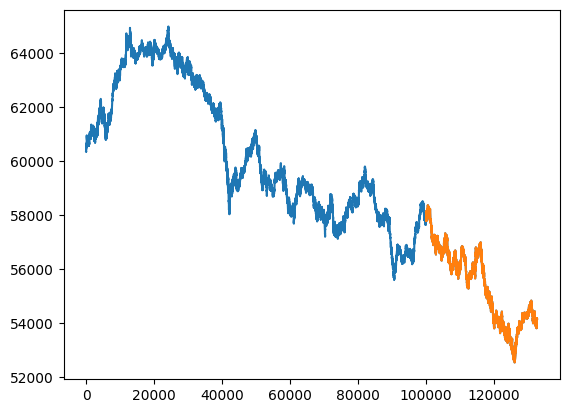

In [44]:
print(orderbook.shape)
plt.plot(orderbook['price'])
orderbook_used = orderbook.iloc[100000:132676,:]
print(orderbook_used['datetime'])
plt.plot(orderbook_used['price'])


## One run trades with one and multiple signals

In [45]:
fee = 0.000002 # fee to simulate price slippage, set to 0.002%
fee = 0.0000002 # fee to simulate price slippage, set to 0.002%

#fee = 0.0001
delay = 2 # delay for placing trade
quantity = 1 # quantity traded
horizon = 10 # main forecasting horizon
input_window = 100 # size of the input window
hfformer = False # True if using HFformer, False if using LSTM
size_trades = True # use size trading 
num_models = 7 # number of models to use to generate trading signal 
min_threshold = True # True if ignoring trade signals below a certain threshold



In [46]:
orderbook_subset = augment_trade_data(orderbook_used, lag=0, forecast_window=horizon)

features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9',
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9']

orderbook_subset = orderbook_subset[features]

/tmp/ipykernel_138857/2638131436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lag_return'] = np.log(df['price'].shift(forecast_window)/df['price'].shift(forecast_window+1))


In [78]:
models = []
# ids = [id for id in range(horizon-num_models//2, horizon+num_models//2+1)]
ids = [i for i in [5,7,9,10,12,13,14]]
#ids = [i for i in [30]]

load_model_name = "lstm"
date = "2024-11-11"

for idx in ids:
    # if hfformer:
    #     models.append(torch.load(f'{current_directory}/{load_model_name}/{model_file_name_struct}{idx}.pt'))
    # else:
        models.append(torch.load(f'{current_directory}/playround_models/{load_model_name}/{date}/No.2/LSTM_MO_LAG_{idx}.pt'))

/tmp/ipykernel_138857/1524194544.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models.append(torch.load(f'{current_directory}/playround_models/{load_model_name}/{date

In [89]:

notional = 40_000
holdings = 0
fee = 0.001/100
max_holdings = 0.1
min_holdings = -0.1
pnl = 0
pnls = []
cum_pnls = []
timerecord = []
cum_notionals = []
total_fees = 0
trade_sizes = [0.15, 0.125, 0.1, 0.075, 0.05, 0.025] #[0.15, 0.125, 0.1, 0.075, 0.05, 0.025] #[0.15, 0.1, 0.05]
trade_size_thresholds = [0.15, 0.125, 0.1, 0.075, 0.05] #[0.25, 0.2, 0.15, 0.1, 0.05] #[0.15, 0.05]
quantities = []

verbose = True

signals_start = []
signals_end = []
signals = []

prev_price = 0

prev_ask = 0
prev_bid = 0
lob_prev_price = 0
start = 0
end = 800_000

for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep + horizon < len(orderbook_subset):

        # 获取当前时间戳
        current_timestamp = orderbook_used.iloc[timestep]["datetime"]

        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=128, shuffle=False, sampler=None, batch_sampler=None, num_workers=0)

        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)

            signals.append(np.array([model(src.float()).detach().cpu().numpy()[0] for model in models]))
            trg = trg.detach().cpu().numpy()[0][0][0]

            if size_trades and holdings == 0:
                quantity = 0
                for idx, threshold in enumerate(trade_size_thresholds):
                    if np.abs(np.sum(signals[-1])) > threshold * len(signals[-1]):
                        quantity = trade_sizes[idx]
                        break
                if not quantity:
                    quantity = trade_sizes[-1]

            if min_threshold and np.abs(np.sum(signals[-1])) < len(signals[-1]) * 0.1 and holdings == 0:
                print(f'\n Not trading as trade signal below threshold \n')
                continue

            # 开仓（做多）
            if np.all((signals[-1] > 0.3)) and holdings == 0:
                holdings += quantity
                notional -= current_midprice * quantity
                notional -= current_midprice * quantity * fee
                prev_ask = current_midprice
                signals_start.append(signals[-1][len(signals[-1]) // 2])
                quantities.append(quantity)
                if verbose:
                    print(f'| Long     | Quantity {quantity} | Ask Price {current_midprice:.2f} | Holdings {holdings} |')
                continue

            # 平仓（做空）
            elif holdings > 0:
                holdings -= quantity
                notional += current_midprice * quantity
                notional -= current_midprice * quantity * fee
                prev_bid = current_midprice
                trade_pnl = (current_midprice - prev_ask) * quantity - (prev_ask + current_midprice) * quantity * fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                timerecord.append(current_timestamp)  # 记录时间戳
                signals_end.append(signals[-1][len(signals[-1]) // 2])
                total_fees += (prev_ask + current_midprice) * quantity * fee
                if verbose:
                    print(f'| Short    | Quantity {quantity} | Bid price {current_midprice:.2f} |')
                    print(f'| PnL {(current_midprice - prev_ask) * quantity:.2f} | Holdings {holdings} |')
                continue

            # 开仓（做空）
            if np.all((signals[-1] < 0.3)) and holdings == 0:
                holdings -= quantity
                notional += current_midprice * quantity
                notional -= current_midprice * quantity * fee
                prev_bid = current_midprice
                signals_start.append(signals[-1][len(signals[-1]) // 2])
                quantities.append(quantity)
                if verbose:
                    print(f'| Short    | Quantity {quantity} | Bid Price {current_midprice:.2f} | Holdings {holdings} |')
                continue

            # 平仓（做多）
            elif holdings < 0:
                holdings += quantity
                notional -= current_midprice * quantity
                notional -= current_midprice * quantity * fee
                prev_ask = current_midprice
                trade_pnl = (prev_bid - current_midprice) * quantity - (prev_bid + current_midprice) * quantity * fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                timerecord.append(current_timestamp)  # 记录时间戳
                signals_end.append(signals[-1][len(signals[-1]) // 2])
                total_fees += (prev_bid + current_midprice) * quantity * fee
                if verbose:
                    print(f'| Long     | Quantity {quantity} | Ask Price {current_midprice:.2f} |')
                    print(f'| PnL {(prev_bid - current_midprice) * quantity:.2f} | Holdings {holdings} |')
                continue

            cum_notionals.append(notional)



| Short    | Quantity 0.15 | Bid Price 57932.18 | Holdings -0.15 |
| Long     | Quantity 0.15 | Ask Price 57997.13 |
| PnL -9.74 | Holdings 0.0 |
| Short    | Quantity 0.15 | Bid Price 58044.73 | Holdings -0.15 |
| Long     | Quantity 0.15 | Ask Price 58041.31 |
| PnL 0.51 | Holdings 0.0 |

 Not trading as trade signal below threshold 

| Short    | Quantity 0.15 | Bid Price 58104.36 | Holdings -0.15 |
| Long     | Quantity 0.15 | Ask Price 58165.75 |
| PnL -9.21 | Holdings 0.0 |
| Short    | Quantity 0.15 | Bid Price 58104.71 | Holdings -0.15 |
| Long     | Quantity 0.15 | Ask Price 58015.71 |
| PnL 13.35 | Holdings 0.0 |
| Short    | Quantity 0.15 | Bid Price 57936.30 | Holdings -0.15 |
| Long     | Quantity 0.15 | Ask Price 57912.86 |
| PnL 3.52 | Holdings 0.0 |
| Short    | Quantity 0.1 | Bid Price 57928.45 | Holdings -0.1 |
| Long     | Quantity 0.1 | Ask Price 58016.61 |
| PnL -8.82 | Holdings 0.0 |
| Long     | Quantity 0.15 | Ask Price 57995.21 | Holdings 0.15 |
| Short    | Qu

Final PnL -99.49 USDT
PnL standard deviation 6.96 USDT
Total number of trades 1142


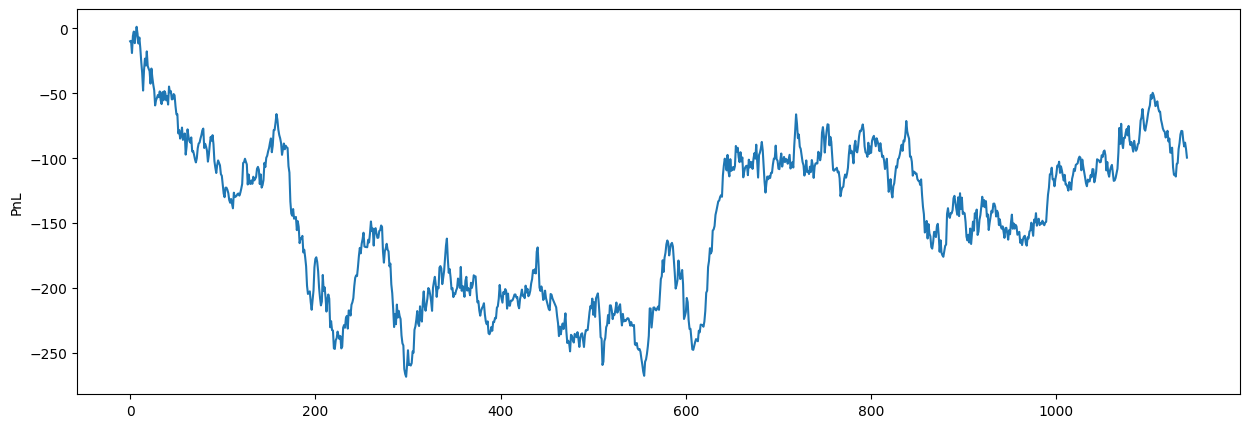

In [90]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 5))
from datetime import datetime
#formatted_times = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S.%f").strftime("%m-%d %H:%M:%S.%f")[:-3]  for ts in timerecord]

#ax2.plot(formatted_times  ,cum_pnls)
ax2.plot(cum_pnls)

#ax2.set_xlabel('Time')
ax2.set_ylabel('PnL')
# ax2.set_xlim(left=0, right=len(cum_pnls))
#selected_indices = [ 100,500, 1000,1500, 2000, 2500,3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500]  # 选择要显示的索引
#ax2.set_xticks([formatted_times [i] for i in selected_indices])  # 设置刻度
#ax2.set_xticklabels([formatted_times [i] for i in selected_indices], rotation=45) 

print(f'Final PnL {cum_pnls[-1]:.2f} USDT')
print(f'PnL standard deviation {np.std(pnls):.2f} USDT')
print(f'Total number of trades {len(cum_pnls)}')

Text(0, 0.5, 'Frequency')

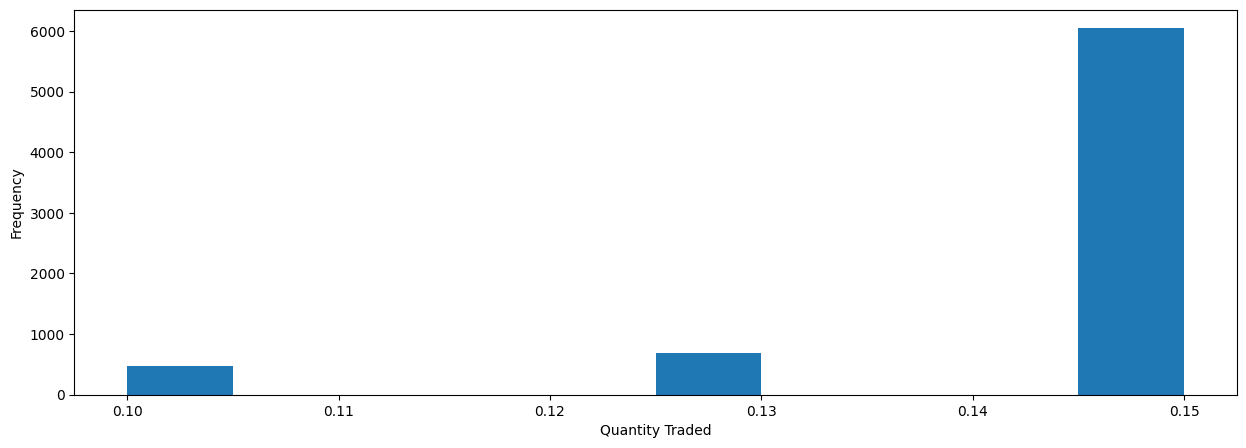

In [15]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 5))
ax2.hist(quantities)
ax2.set_xlabel('Quantity Traded')
ax2.set_ylabel('Frequency')

In [16]:
if False :
    fig2, ax2 = plt.subplots(1, 1, figsize = (15, 5))
    quantities = np.array(quantities)
    ax2.hist(quantities, alpha=.8)
    ax2.hist(quantities[np.array(pnls) > 0], color='green', label="Profitable")
    ax2.hist(quantities[np.array(pnls) < 0], color='red', label="Unprofitable", alpha=0.5)
    ax2.set_xlabel('Quantity Traded')
    ax2.set_ylabel('Frequency')
    ax2.legend(loc='best')


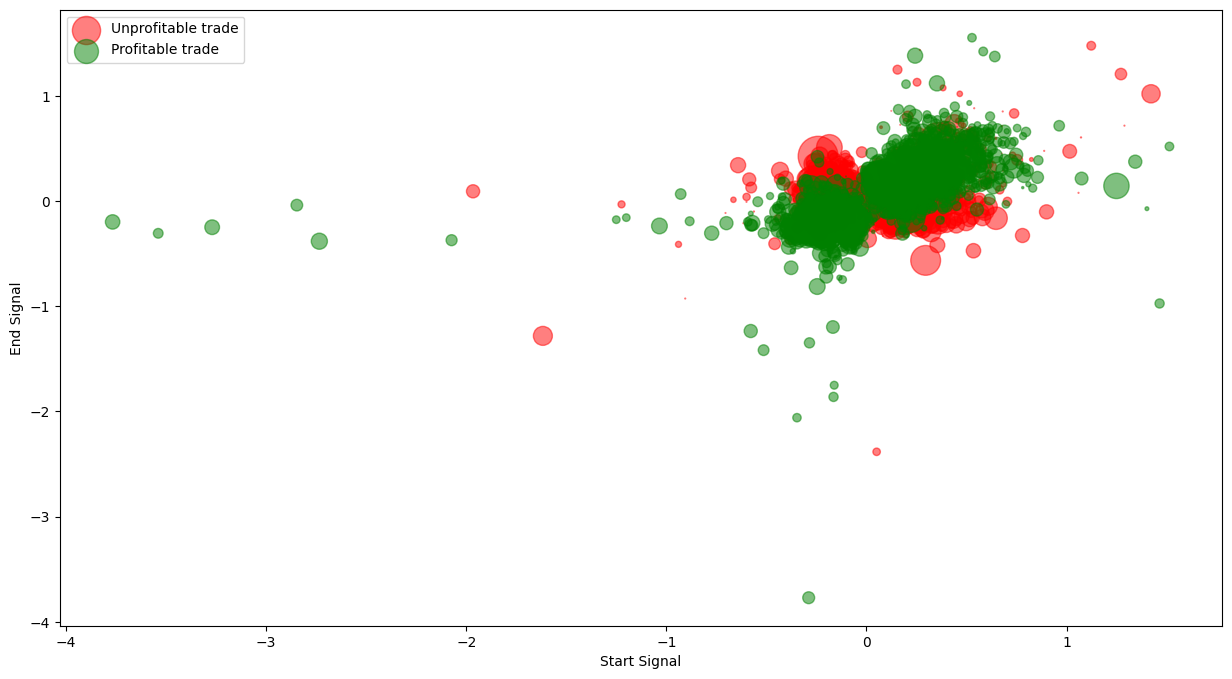

In [17]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 8))

signals_start = np.array(signals_start)[:len(pnls)]
signals_end = np.array(signals_end)[:len(pnls)]
pnls = pnls = np.array(pnls)

signals_start_profit = signals_start[np.array(pnls)>0]
signals_end_profit = signals_end[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_start_loss = signals_start[np.array(pnls)<0]
signals_end_loss = signals_end[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax2.scatter(signals_start_loss[:len(signals_end_loss)], signals_end_loss[:len(signals_start_loss)], s=np.abs(pnls_loss)*100, alpha=0.5, color='red', label='Unprofitable trade')
ax2.scatter(signals_start_profit[:len(signals_end_profit)], signals_end_profit[:len(signals_start_profit)], s=np.abs(pnls_profit)*100, alpha=0.5, color='green', label='Profitable trade')

ax2.set_xlabel('Start Signal')
ax2.set_ylabel('End Signal')
ax2.legend(loc='best')

In [18]:
signals_start[np.array(pnls)>0]
%cd /mnt/workspace/shell/backtest/{load_model_name}


[Errno 2] No such file or directory: '/mnt/workspace/shell/backtest/LSTM'
/home/gaen/Documents/codespace-gaen/Ts-master


In [19]:
fileobj = open('./pnls_lstm_7signals_sized_tradesv4.pkl', 'wb')
pickle.dump(pnls, fileobj)
fileobj.close()

fileobj = open('./cum_pnls_lstm_7signals_sized_tradesv4.pkl', 'wb')
pickle.dump(cum_pnls, fileobj)
fileobj.close()


fileobj = open('./quantities_lstm_7signals_sized_tradesv4.pkl', 'wb')
pickle.dump(quantities, fileobj)
fileobj.close()

fileobj = open('./signals_start.pkl', 'wb')
pickle.dump(signals_start, fileobj)
fileobj.close()

In [20]:
with open(f'{current_directory}/backtest/{load_model_name}/pnls_lstm_7signals_sized_tradesv4.pkl', 'rb') as f:
    pnl_lstm = pickle.load(f)


FileNotFoundError: [Errno 2] No such file or directory: '/home/gaen/Documents/codespace-gaen/Ts-master/backtest/LSTM/pnl_lstm_7signals.pkl'

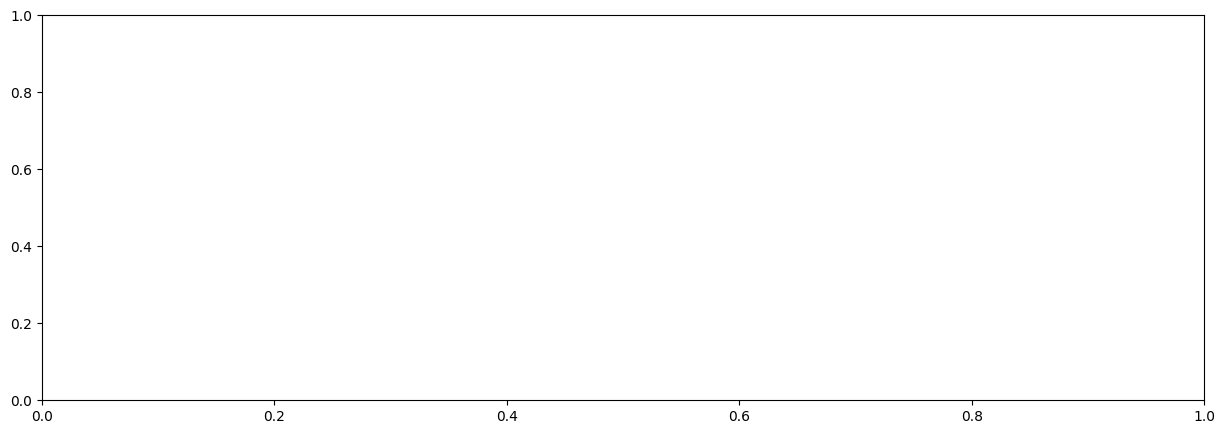

In [21]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 5))


# ax2.plot(pickle.load(open(f'{current_directory}/backtest/{load_model_name}/pnl_lstm_1signals.pkl', 'rb')), label='lstm: 1 signal')
# ax2.plot(pickle.load(open(f'{current_directory}/backtest/{load_model_name}/pnl_lstm_3signals.pkl', 'rb')), label='lstm: 3 signals')
# ax2.plot(pickle.load(open(f'{current_directory}/backtest/{load_model_name}/pnl_lstm_5signals.pkl', 'rb')), label='lstm: 5 signals')
ax2.plot(pickle.load(open(f'{current_directory}/backtest/{load_model_name}/pnl_lstm_7signals.pkl', 'rb')), label='lstm: 7 signals')
# ax2.plot(pickle.load(open(f'{current_directory}/backtest/{load_model_name}/pnl_lstm_9signals.pkl', 'rb')), label='lstm: 9 signals')
# ax2.plot(pickle.load(open(f'{current_directory}/backtest/{load_model_name}/pnl_lstm_11signals.pkl', 'rb')), label='lstm: 11 signals')

ax2.set_xlabel('Trades')
ax2.set_ylabel('PnL')
ax2.set_xlim(left=0, right=len(pickle.load(open(f'{current_directory}/backtest/{load_model_name}/pnl_lstm_7signals.pkl', 'rb'))))
ax2.legend(loc='best')

fig2.savefig(f'./pnl_lstm_different_signals.pdf', dpi=300, bbox_inches='tight')

In [ ]:
signals_num = [1,3,5,7,9,11]
lengths = np.array([len(pickle.load(open(f'{current_directory}/backtest/{load_model_name}/pnl_hfformer_{idx}signals.pkl', 'rb'))) for idx in signals_num])
final_pnls = np.array([pickle.load(open(f'{current_directory}/backtest/{load_model_name}/pnl_hfformer_{idx}signals.pkl', 'rb'))[-1] for idx in signals_num])

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 5))
ax2.plot(cum_pnls, label='HFformer')
ax2.plot(pnl_lstm, label='LSTM')


ax2.set_xlabel('Trades')
ax2.set_ylabel('PnL')
# ax2.set_title(f'Log Returns - HFformer - {asset}')
# ax2.set_ylim(bottom=0.3,top=0.9)
ax2.set_xlim(left=0 , right=len(pnl_lstm))
ax2.legend(loc='best')

fig2.savefig(f'./pnl_strategy1_lstm_hfformer.pdf', dpi=300, bbox_inches='tight')

NameError: name 'signals_1' is not defined

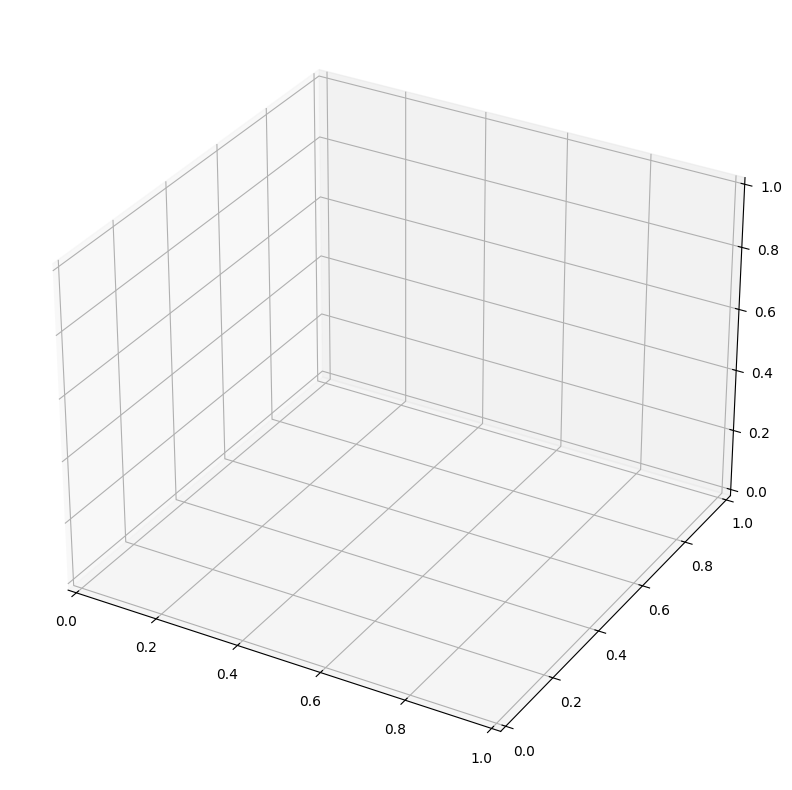

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

signals_1 = np.array(signals_1)[:len(pnls)]
signals_2 = np.array(signals_2)[:len(pnls)]
signals_3 = np.array(signals_3)[:len(pnls)]
pnls = np.array(pnls)

signals_1_profit = signals_1[np.array(pnls)>0]
signals_2_profit = signals_2[np.array(pnls)>0]
signals_3_profit = signals_3[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_1_loss = signals_1[np.array(pnls)<0]
signals_2_loss = signals_2[np.array(pnls)<0]
signals_3_loss = signals_3[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax.scatter(signals_1_profit, signals_2_profit, signals_3_profit, s=np.abs(pnls_profit)*100, color='green', alpha=0.4)
ax.scatter(signals_1_loss, signals_2_loss, signals_3_loss, s=np.abs(pnls_loss)*100, color='red', alpha=0.3)

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 8))

signals_start = np.array(signals_start)[:len(pnls)]
signals_end = np.array(signals_end)[:len(pnls)]
pnls = pnls = np.array(pnls)

signals_start_profit = signals_start[np.array(pnls)>0]
signals_end_profit = signals_end[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_start_loss = signals_start[np.array(pnls)<0]
signals_end_loss = signals_end[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax2.scatter(signals_start_loss[:len(signals_end_loss)], signals_end_loss[:len(signals_start_loss)], s=np.abs(pnls_loss)*100, alpha=0.5, color='red', label='Unprofitable trade')
ax2.scatter(signals_start_profit[:len(signals_end_profit)], signals_end_profit[:len(signals_start_profit)], s=np.abs(pnls_profit)*100, alpha=0.5, color='green', label='Profitable trade')

ax2.set_xlabel('Start Signal')
ax2.set_ylabel('End Signal')
ax2.legend(loc='best')

# fig2.savefig(f'./trades_cloud_buy_hfformer_1signals.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 8))

signals_1 = np.array(signals_1)[:len(pnls)]
signals_2 = np.array(signals_2)[:len(pnls)]
pnls = pnls = np.array(pnls)

signals_1_profit = signals_1[np.array(pnls)>0]
signals_2_profit = signals_2[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_1_loss = signals_1[np.array(pnls)<0]
signals_2_loss = signals_2[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax2.scatter(signals_1_profit[:len(signals_2_profit)], signals_2_profit[:len(signals_1_profit)], s=np.abs(pnls_profit)*100, alpha=0.5, color='green', label='Profitable trade')
ax2.scatter(signals_1_loss[:len(signals_2_loss)], signals_2_loss[:len(signals_1_loss)], s=np.abs(pnls_loss)*100, alpha=0.5, color='red', label='Unprofitable trade')

ax2.set_xlabel('Signal 1')
ax2.set_ylabel('Signal 2')
ax2.set_ylim(bottom=-0.4,top=0.4)
ax2.set_xlim(left=-0.4,right=0.4)
ax2.legend(loc='best')


In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 8))

signals_1 = np.array(signals_1)[:len(pnls)]
signals_3 = np.array(signals_3)[:len(pnls)]
pnls = pnls = np.array(pnls)

signals_1_profit = signals_1[np.array(pnls)>0]
signals_3_profit = signals_3[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_1_loss = signals_1[np.array(pnls)<0]
signals_3_loss = signals_3[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax2.scatter(signals_1_profit[:len(signals_3_profit)], signals_3_profit[:len(signals_1_profit)], s=np.abs(pnls_profit)*100, alpha=0.5, color='green', label='Profitable trade')
ax2.scatter(signals_1_loss[:len(signals_3_loss)], signals_3_loss[:len(signals_1_loss)], s=np.abs(pnls_loss)*100, alpha=0.5, color='red', label='Unprofitable trade')

ax2.set_xlabel('Signal 1')
ax2.set_ylabel('Signal 3')
ax2.set_ylim(bottom=-0.6,top=0.6)
ax2.set_xlim(left=-0.6,right=0.6)
ax2.legend(loc='best')

In [ ]:
signals_df = pd.DataFrame({'pnl':pnls, 'signal1':signals_1, 'signal2':signals_2, 'signal3':signals_3, 'signal4':signals_4, 'signal5':signals_5 })

In [ ]:
signals_df.corr()

## One run trades with +2/-2 horizon indicators

In [10]:
fee = 0.0000002 # fee to simulate price slippage, set to 0.002%
delay = 2
quantity = 0.1
horizon = 10
input_window = 100

In [11]:
orderbook_subset = augment_trade_data(orderbook, lag=0, forecast_window=horizon)

features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9',
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9']

orderbook_subset = orderbook_subset[features]

In [ ]:
model = torch.load(f'{current_directory}/{load_model_name}/{model_file_name_struct}{horizon}.pt')
model2 = torch.load(f'{current_directory}/{load_model_name}/{model_file_name_struct}{horizon+2}.pt')
model3 = torch.load(f'{current_directory}/{load_model_name}/{model_file_name_struct}{horizon-2}.pt')

In [ ]:
notional = 40_000
holdings = 0
max_holdings = 0.1
min_holdings = -0.1
pnl = 0
pnls = []
cum_pnls = []
cum_notionals = []
returns = []
total_fees = 0

verbose = True

signal = 0
prev_signal = 0 
signals_start = []
signals_end = []
prev_price = 0
prev_ask = 0
prev_bid = 0
lob_prev_price = 0
start = 0
end = 800_000
counter, correct_signal_counter = 0, 0 

for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep+horizon < len(orderbook_subset):

        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0)
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            signal = model(src.float())
            signal_secondary = model2(src.float())
            signal_tertiary = model3(src.float())
            signal = signal.detach().cpu().numpy()[0][0]
            signal_secondary = signal_secondary.detach().cpu().numpy()[0][0]
            signal_tertiary = signal_tertiary.detach().cpu().numpy()[0][0]
            trg = trg.detach().cpu().numpy()[0][0][0]

            if verbose:
                None
                print(f'signal {signal:.3f}, secondary signal {signal_secondary:.3f} tertiary signal {signal_tertiary:.3f}, trg {trg:.3f}')
                print(f'signal {signal:.3f}, return short {np.log(future_ask/current_bid_price)*10_000:.3f}')
                print(f'signal {signal:.3f}, return long {np.log(future_bid/current_ask_price)*10_000:.3f}')


            counter += 1
            correct_signal_counter = correct_signal_counter+1 if signal*trg > 0 else correct_signal_counter+0
            # print(f'Signal ratio: {correct_signal_counter/counter}') 

        
            if signal > 0 and signal_secondary > 0 and signal_tertiary > 0 and holdings == 0:
                print(timestep)
                holdings += quantity
                notional -= current_midprice*quantity
                notional -= current_midprice*quantity*fee
                prev_signal = signal
                prev_ask = current_midprice
                signals_start.append(signal)
                if verbose:
                    print(f'Long: quantity {quantity}, ask price {current_midprice:.2f}, holdings {holdings}')
                    # print(f'future midprice {current_midprice:.2f}')
                continue
            elif holdings > 0:
                print(timestep)
                holdings -= quantity
                notional += current_midprice*quantity 
                notional -= current_midprice*quantity*fee
                prev_signal = signal 
                prev_bid = current_midprice
                trade_pnl = (current_midprice - prev_ask)*quantity - (prev_ask+current_midprice)*quantity*fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                total_fees += (prev_ask+current_midprice)*quantity*fee
                signals_end.append(signal)
                returns.append((current_midprice - prev_ask)/prev_ask)
                if verbose:
                    print(f'Short: quantity {quantity}, bid price {current_midprice:.2f}')
                    print(f'PnL: {(current_midprice - prev_ask)*quantity:.2f}, Holdings: {holdings}')
                    print('\n')
                continue
            

            if signal < 0 and signal_secondary < 0 and signal_tertiary < 0 and holdings == 0:
                holdings -= quantity
                notional += current_midprice*quantity
                notional -= current_midprice*quantity*fee
                prev_signal = signal
                prev_bid = current_midprice
                signals_start.append(signal)
                if verbose:
                    print(f'Short: quantity {quantity}, bid price {current_midprice:.2f}, holdings {holdings}')
                    # print(f'future midprice {current_midprice:.2f}')
                continue
            elif holdings < 0:
                holdings += quantity
                notional -= current_midprice*quantity 
                notional -= current_midprice*quantity*fee
                prev_signal = signal
                prev_ask = current_midprice
                trade_pnl = (prev_bid - current_midprice)*quantity - (prev_bid+current_midprice)*quantity*fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                total_fees += (prev_bid+current_midprice)*quantity*fee
                signals_end.append(signal)
                returns.append((prev_bid - current_midprice)/prev_bid)
                if verbose:
                    print(f'Long: quantity {quantity}, ask price {current_midprice:.2f}')
                    print(f'PnL: {(prev_bid - current_midprice)*quantity:.2f}, Holdings: {holdings}')
                    print('\n')
                continue
                    
            cum_notionals.append(notional)
                
        # if timestep % 100 == 0:
        #     print(f'Notional: {notional}')
        #     print(f'PnL: {pnl:.2f}, Quantity: {quantity}')
        #     print(f'Holding: {holdings}')
        #     print(f'Fees: {total_fees:.2f}')

In [ ]:
print(f'mean {np.mean(pnls)}')
print(f'median {np.median(pnls)}')
print(f'std {np.std(pnls)}')
print(f'max {np.max(pnls)}')
print(f'min {np.min(pnls)}')

In [ ]:
plt.hist(pnls, bins=40)

In [ ]:
share_ratio = np.mean(returns)/np.std(returns)
print(share_ratio)

In [ ]:
plt.plot(cum_pnls)

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 5))

ax2.plot(orderbook['price'])

ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Weighted Midprice')
ax2.set_xlim(left=0,right=len(orderbook))

fig2.savefig(f'./midprice_backtest/{load_model_name}.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize = (15, 8))

signals_start = np.array(signals_start)[:len(pnls)]
signals_end = np.array(signals_end)[:len(pnls)]
pnls = pnls = np.array(pnls)

signals_start_profit = signals_start[np.array(pnls)>0]
signals_end_profit = signals_end[np.array(pnls)>0]
pnls_profit = pnls[np.array(pnls)>0] 

signals_start_loss = signals_start[np.array(pnls)<0]
signals_end_loss = signals_end[np.array(pnls)<0]
pnls_loss = pnls[np.array(pnls)<0] 

ax2.scatter(signals_start_profit[:len(signals_end_profit)], signals_end_profit[:len(signals_start_profit)], s=np.abs(pnls_profit), alpha=0.5, color='green', label='Profitable trade')
ax2.scatter(signals_start_loss[:len(signals_end_loss)], signals_end_loss[:len(signals_start_loss)], s=np.abs(pnls_loss), alpha=0.5, color='red', label='Unprofitable trade')

ax2.set_xlabel('Start Signal')
ax2.set_ylabel('End Signal')
ax2.set_ylim(bottom=-0.4,top=0.4)
ax2.set_xlim(left=-0.4,right=0.4)
ax2.legend(loc='best')

fig2.savefig(f'./trades_cloud_buy_window2.pdf', dpi=300, bbox_inches='tight')

## Trades hold until signal changes sign 

In [28]:
fee = 0.000002
delay = 1
quantity = 0.15
horizon = 28
input_window = 100

In [29]:
orderbook_subset = augment_trade_data(orderbook, lag=0, forecast_window=horizon)

features = ['price', 'lag_return',
                'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
                'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9',
                'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
                'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9']

orderbook_subset = orderbook_subset[features]

In [30]:
model = torch.load(f'{current_directory}/{load_model_name}/{model_file_name_struct}{horizon}.pt')
model2 = torch.load(f'{current_directory}/{load_model_name}/{model_file_name_struct}{horizon+2}.pt')
model3 = torch.load(f'{current_directory}/{load_model_name}/{model_file_name_struct}{horizon-2}.pt')
model4 = torch.load(f'{current_directory}/{load_model_name}/{model_file_name_struct}{horizon+1}.pt')
model5 = torch.load(f'{current_directory}/{load_model_name}/{model_file_name_struct}{horizon-1}.pt')

/tmp/ipykernel_125891/345940810.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'/home/gaen/Documents/codespace-gaen/Simons/{load_model_name}/{model_

In [3]:
## original
notional = 40_000
holdings = 0
max_holdings = 0.1
min_holdings = -0.1
pnl = 0
pnls = []
cum_pnls = []
cum_notionals = []
total_fees = 0
trade_sizes = [0.15, 0.125, 0.1, 0.075, 0.05, 0.025] #[0.15, 0.125, 0.1, 0.075, 0.05, 0.025] #[0.15, 0.1, 0.05]
trade_size_thresholds = [0.15, 0.125, 0.1, 0.075, 0.05] #[0.25, 0.2, 0.15, 0.1, 0.05] #[0.15, 0.05]
quantities = []

verbose = True

signals_start = []
signals_end = []
signals = []

prev_price = 0
prev_ask = 0
prev_bid = 0
lob_prev_price = 0
start = 0
end = 800_000

for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep+horizon < len(orderbook_subset):

        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0)
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)

            if hfformer:
                signals.append(np.array([model(src.float()).detach().cpu().numpy()[0][0] for model in models]))
            else:
                signals.append(np.array([model(src.float()).detach().cpu().numpy()[0] for model in models]))

            trg = trg.detach().cpu().numpy()[0][0][0]

            if size_trades and holdings == 0:
                quantity = 0
                for idx, threshold in enumerate(trade_size_thresholds):
                    if np.abs(np.sum(signals[-1])) > threshold*len(signals[-1]):
                        quantity = trade_sizes[idx]
                        break
                if not quantity:  
                    quantity = trade_sizes[-1]
            
            if min_threshold and np.abs(np.sum(signals[-1])) < len(signals[-1])*0.1 and holdings == 0:
                print(f'\n Not trading as trade signal below threshold \n')
                continue

            if np.all((signals[-1] > 0)) and holdings == 0:
                holdings += quantity
                notional -= current_midprice*quantity
                notional -= current_midprice*quantity*fee
                prev_ask = current_midprice
                signals_start.append(signals[-1][len(signals[-1])//2])
                quantities.append(quantity)
                if verbose:
                    print(f'| Long     | Quantity {quantity} | Ask Price {current_midprice:.2f} | Holdings {holdings} |')
                    # print(f'future midprice {current_midprice:.2f}')
                continue
            elif holdings > 0:
                holdings -= quantity
                notional += current_midprice*quantity 
                notional -= current_midprice*quantity*fee
                prev_bid = current_midprice
                trade_pnl = (current_midprice - prev_ask)*quantity - (prev_ask+current_midprice)*quantity*fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                signals_end.append(signals[-1][len(signals[-1])//2])
                total_fees += (prev_ask+current_midprice)*quantity*fee
                if verbose:
                    print(f'| Short    | Quantity {quantity} | Bid price {current_midprice:.2f} |')
                    print(f'| PnL {(current_midprice - prev_ask)*quantity:.2f} | Holdings {holdings} |')
                    print('\n')
                continue
            

            if np.all((signals[-1] < 0)) and holdings == 0:
                holdings -= quantity
                notional += current_midprice*quantity
                notional -= current_midprice*quantity*fee
                prev_bid = current_midprice
                signals_start.append(signals[-1][len(signals[-1])//2])
                quantities.append(quantity)
                if verbose:
                    print(f'| Short    | Quantity {quantity} | Bid Price {current_midprice:.2f} | Holdings {holdings} |')
                    # print(f'future midprice {current_midprice:.2f}')
                continue
            elif holdings < 0:
                holdings += quantity
                notional -= current_midprice*quantity 
                notional -= current_midprice*quantity*fee
                prev_ask = current_midprice
                trade_pnl = (prev_bid - current_midprice)*quantity - (prev_bid+current_midprice)*quantity*fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                signals_end.append(signals[-1][len(signals[-1])//2])
                total_fees += (prev_bid+current_midprice)*quantity*fee
                if verbose:
                    print(f'| Long     | Quantity {quantity} | Ask Price {current_midprice:.2f} |')
                    print(f'| PnL {(prev_bid - current_midprice)*quantity:.2f} | Holdings {holdings} |')
                    print(f'\n')
                continue
                    
            cum_notionals.append(notional)
                
        if timestep % 100 == 0:
            None
        #     print(f'Notional: {notional}')
        #     print(f'PnL: {pnl:.2f}, Quantity: {quantity}')
        #     print(f'Holding: {holdings}')
        #     print(f'Fees: {total_fees:.2f}')

    plt.plot(cum_pnls)


In [4]:
notional = 40000
holdings = 0
max_holdings = 0.1
min_holdings = -0.1
pnl = 0
pnls = []
cum_pnls = []
cum_notionals = []
total_fees = 0
quantity = 0.15
verbose = True

signal = 0
prev_signal = 0 
signals_start = []
signals_end = []
prev_price = 0
prev_ask = 0
prev_bid = 0
lob_prev_price = 0
start = 0
end = 800_000
counter, correct_signal_counter = 0, 0 

for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep+horizon < len(orderbook_subset):

        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0)
        
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            signal = model(src.float())
            signal_secondary = model2(src.float())
            signal_tertiary = model3(src.float())
            signal_4th = model4(src.float())
            signal_5th = model5(src.float())
            signal = signal.detach().cpu().numpy()[0][0]
            signal_secondary = signal_secondary.detach().cpu().numpy()[0][0]
            signal_tertiary = signal_tertiary.detach().cpu().numpy()[0][0]
            signal_4th = signal_4th.detach().cpu().numpy()[0][0]
            signal_5th = signal_5th.detach().cpu().numpy()[0][0]
            trg = trg.detach().cpu().numpy()[0][0][0]
            #quantity = notional / current_bid_price
            if verbose:
                None
                #print(f'signal {signal:.3f}, secondary signal {signal_secondary:.3f} tertiary signal {signal_tertiary:.3f}, trg {trg:.3f}')
                #print(f'signal {signal:.3f}, return short {np.log(future_ask/current_bid_price)*10_000:.3f}')
                #print(f'signal {signal:.3f}, return long {np.log(future_bid/current_ask_price)*10_000:.3f}')


            counter += 1
            correct_signal_counter = correct_signal_counter+1 if signal*trg > 0 else correct_signal_counter+0
            print(f'Signal ratio: {correct_signal_counter/counter}') 

            
            if holdings == 0:
                if signal  < 0:
                    short = True
                    print('SHORT')
                else:
                    print('LONG')
                    short = False 
            #quantity = notional / current_bid_price
            if short:
                if signal > 0 and signal_secondary > 0 and signal_tertiary > 0 and signal_4th > 0 and signal_5th > 0 and holdings < 0:
                    holdings += quantity
                    notional -= current_ask_price*quantity
                    notional -= current_ask_price*quantity*fee
                    prev_signal = signal
                    prev_ask = current_ask_price
                    trade_pnl = (prev_bid-current_ask_price)*quantity - (prev_bid+current_ask_price)*quantity*fee
                    pnl += trade_pnl
                    pnls.append(trade_pnl)
                    cum_pnls.append(pnl)
                    total_fees += (prev_bid+current_ask_price)*quantity*fee
                    signals_end.append(signal)
                    if verbose:
                        print(f'Long: quantity {quantity} ask price {current_ask_price:.2f}')
                        print(f'PnL: {(prev_bid-current_ask_price)*quantity:.2f}, Holdings: {holdings}')
                        print('\n')
                elif signal < 0 and signal_secondary < 0 and signal_tertiary < 0 and signal_4th < 0 and signal_5th < 0 and holdings == 0:
                    holdings -= quantity
                    notional += current_bid_price*quantity
                    notional -= current_bid_price*quantity*fee
                    prev_signal = signal
                    prev_bid = current_bid_price
                    signals_start.append(signal)
                    if verbose:
                        print(f'Short: quantity {quantity}, bid price {current_bid_price}, holdings {holdings}')
            
            else:
                if signal > 0 and signal_secondary > 0 and signal_tertiary > 0 and signal_4th > 0 and signal_5th > 0 and holdings = 0:
                    holdings += quantity
                    notional -= current_ask_price*quantity
                    notional -= current_ask_price*quantity*fee
                    prev_signal = signal
                    prev_ask = current_ask_price
                    signals_start.append(signal)
                    if verbose:
                        print(f'Long: quantity {quantity}, ask price {current_ask_price:.2f}, holdings {holdings}')
                elif signal < 0 and signal_secondary < 0 and signal_tertiary < 0 and signal_4th < 0 and signal_5th < 0 and holdings > 0:
                    holdings -= quantity
                    notional += current_bid_price*quantity 
                    notional -= current_bid_price*quantity*fee
                    prev_signal = signal
                    prev_bid = current_bid_price
                    trade_pnl = (current_bid_price - prev_ask)*quantity - (prev_ask+current_bid_price)*quantity*fee
                    pnl += trade_pnl
                    pnls.append(trade_pnl)
                    cum_pnls.append(pnl)
                    total_fees += (prev_ask+current_bid_price)*quantity*fee
                    signals_end.append(signal)
                    if verbose:
                        print(f'Short: quantity {quantity}, bid price {current_bid_price}')
                        print(f'PnL: {(current_bid_price - prev_ask)*quantity:.2f}, Holdings: {holdings}')
                        print('\n')
                        
            cum_notionals.append(notional)
                
        if timestep % 1_000 == 0:
            print(f'Notional: {notional}')
            print(f'PnL: {cum_pnls[-1]:.2f}, Quantity: {quantity}')
            print(f'Holding: {holdings}')
            print(f'Fees: {total_fees:.2f}')

SyntaxError: invalid syntax (2929207555.py, line 96)

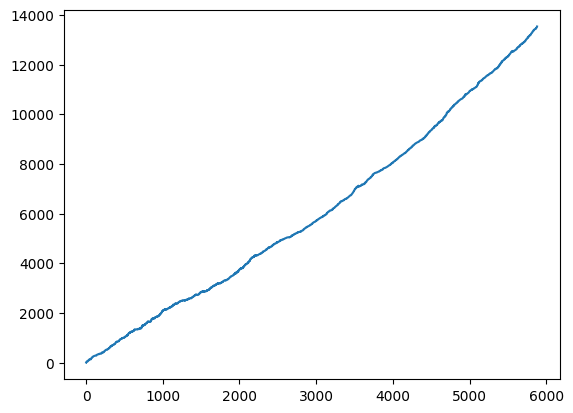

In [36]:
plt.plot(cum_pnls)
cipml= cum_pnls


In [ ]:
import numpy as np

notional = 40000
holdings = 0
max_holdings = 0.1
min_holdings = -0.1
pnl = 0
pnls = []
cum_pnls = []
cum_notionals = []
total_fees = 0
verbose = True

trade_sizes = [0.15, 0.125, 0.1, 0.075, 0.05, 0.025]
trade_size_thresholds = [0.15, 0.125, 0.1, 0.075, 0.05]

signal = 0
prev_signal = 0 
signals_start = []
signals_end = []
prev_price = 0
prev_ask = 0
prev_bid = 0
lob_prev_price = 0
start = 0
end = 800_000
counter, correct_signal_counter = 0, 0 

def get_trade_size(signals):
    avg_signal = np.mean(np.abs(signals))
    for i, threshold in enumerate(trade_size_thresholds):
        if avg_signal >= threshold:
            return trade_sizes[i]
    return trade_sizes[-1]

for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep+horizon < len(orderbook_subset):

        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0)
        
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            signal = model(src.float()).detach().cpu().numpy()[0][0]
            signal_secondary = model2(src.float()).detach().cpu().numpy()[0][0]
            signal_tertiary = model3(src.float()).detach().cpu().numpy()[0][0]
            signal_4th = model4(src.float()).detach().cpu().numpy()[0][0]
            signal_5th = model5(src.float()).detach().cpu().numpy()[0][0]
            trg = trg.detach().cpu().numpy()[0][0][0]

            signals = [signal, signal_secondary, signal_tertiary, signal_4th, signal_5th]
            quantity = get_trade_size(signals) * notional / current_bid_price

            if verbose:
                print(f'Signals: {signals}')
                print(f'Average signal: {np.mean(signals):.3f}, Quantity: {quantity:.3f}')
                print(f'Return short {np.log(future_ask/current_bid_price)*10_000:.3f}')
                print(f'Return long {np.log(future_bid/current_ask_price)*10_000:.3f}')

            counter += 1
            correct_signal_counter = correct_signal_counter+1 if signal*trg > 0 else correct_signal_counter+0

            all_positive = all(s > 0 for s in signals)
            all_negative = all(s < 0 for s in signals)

            if all_negative and holdings >= 0:
                # Short
                trade_quantity = min(quantity, holdings + max_holdings * notional / current_bid_price)
                holdings -= trade_quantity
                notional += current_bid_price * trade_quantity
                notional -= current_bid_price * trade_quantity * fee
                prev_bid = current_bid_price
                signals_start.append(signals)
                if verbose:
                    print(f'Short: quantity {trade_quantity}, bid price {current_bid_price}, holdings {holdings}')

            elif all_positive and holdings <= 0:
                # Long
                trade_quantity = min(quantity, max_holdings * notional / current_ask_price - holdings)
                holdings += trade_quantity
                notional -= current_ask_price * trade_quantity
                notional -= current_ask_price * trade_quantity * fee
                prev_ask = current_ask_price
                signals_start.append(signals)
                if verbose:
                    print(f'Long: quantity {trade_quantity}, ask price {current_ask_price}, holdings {holdings}')

            if holdings != 0:
                # Calculate PnL
                if holdings > 0:
                    trade_pnl = (current_bid_price - prev_ask) * holdings - (prev_ask + current_bid_price) * holdings * fee
                else:
                    trade_pnl = (prev_bid - current_ask_price) * holdings - (prev_bid + current_ask_price) * abs(holdings) * fee
                
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                total_fees += (prev_ask + current_bid_price) * abs(holdings) * fee
                signals_end.append(signals)

                if verbose:
                    print(f'PnL: {trade_pnl:.2f}, Total PnL: {pnl:.2f}, Holdings: {holdings}')
                    print('\n')

            cum_notionals.append(notional)
                
        if timestep % 1_000 == 0:
            print(f'Notional: {notional}')
            print(f'PnL: {cum_pnls[-1]:.2f}, Current holdings: {holdings}')
            print(f'Total Fees: {total_fees:.2f}')

In [ ]:
plt.plot(cum_pnls)

In [ ]:
import numpy as np

notional = 40000
holdings = 0
max_holdings = 0.1
min_holdings = -0.1
pnl = 0
pnls = []
cum_pnls = []
cum_notionals = []
total_fees = 0
verbose = True

trade_sizes = [0.15, 0.125, 0.1, 0.075, 0.05, 0.025]
trade_size_thresholds = [0.15, 0.125, 0.1, 0.075, 0.05]

signal = 0
prev_signal = 0 
signals_start = []
signals_end = []
prev_price = 0
prev_ask = 0
prev_bid = 0
lob_prev_price = 0
start = 0
end = 800_000
counter, correct_signal_counter = 0, 0 

def get_trade_size(signals):
    avg_signal = np.mean(np.abs(signals))
    for i, threshold in enumerate(trade_size_thresholds):
        if avg_signal >= threshold:
            return trade_sizes[i]
    return trade_sizes[-1]

for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep+horizon < len(orderbook_subset):

        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0)
        
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            signal = model(src.float()).detach().cpu().numpy()[0][0]
            signal_secondary = model2(src.float()).detach().cpu().numpy()[0][0]
            signal_tertiary = model3(src.float()).detach().cpu().numpy()[0][0]
            signal_4th = model4(src.float()).detach().cpu().numpy()[0][0]
            signal_5th = model5(src.float()).detach().cpu().numpy()[0][0]
            trg = trg.detach().cpu().numpy()[0][0][0]

            signals = [signal, signal_secondary, signal_tertiary, signal_4th, signal_5th]
            trade_size = get_trade_size(signals)

            if verbose:
                print(f'Signals: {signals}')
                print(f'Average signal: {np.mean(signals):.3f}, Trade size: {trade_size:.3f}')
                print(f'Return short {np.log(future_ask/current_bid_price)*10_000:.3f}')
                print(f'Return long {np.log(future_bid/current_ask_price)*10_000:.3f}')

            counter += 1
            correct_signal_counter = correct_signal_counter+1 if signal*trg > 0 else correct_signal_counter+0

            all_positive = all(s > 0 for s in signals)
            all_negative = all(s < 0 for s in signals)

            if all_negative:
                # Withdraw
                if holdings > 0:
                    trade_quantity = min(holdings, trade_size * notional / current_bid_price)
                    holdings -= trade_quantity
                    notional += current_bid_price * trade_quantity
                    notional -= current_bid_price * trade_quantity * fee
                    signals_end.append(signals)
                    if verbose:
                        print(f'Withdraw: quantity {trade_quantity}, bid price {current_bid_price}, holdings {holdings}')

            elif all_positive:
                # Invest
                trade_quantity = min(trade_size * notional / current_ask_price, max_holdings * notional / current_ask_price - holdings)
                holdings += trade_quantity
                notional -= current_ask_price * trade_quantity
                notional -= current_ask_price * trade_quantity * fee
                signals_start.append(signals)
                if verbose:
                    print(f'Invest: quantity {trade_quantity}, ask price {current_ask_price}, holdings {holdings}')

            # Calculate PnL
            if holdings != 0:
                trade_pnl = (current_bid_price - prev_ask) * holdings - (prev_ask + current_bid_price) * abs(holdings) * fee
                pnl += trade_pnl
                pnls.append(trade_pnl)
                cum_pnls.append(pnl)
                total_fees += (prev_ask + current_bid_price) * abs(holdings) * fee

                if verbose:
                    print(f'PnL: {trade_pnl:.2f}, Total PnL: {pnl:.2f}, Holdings: {holdings}')
                    print('\n')

            prev_ask = current_ask_price
            prev_bid = current_bid_price
            cum_notionals.append(notional)
                
        if timestep % 1_000 == 0:
            print(f'Notional: {notional}')
            print(f'PnL: {cum_pnls[-1]:.2f}, Current holdings: {holdings}')
            print(f'Total Fees: {total_fees:.2f}')

plt.plot(cum_pnls)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Initial Parameters
notional = 40000  # Starting cash balance
holdings = 0  # Quantity of asset held
entry_price = None  # Price at which the current position was entered
max_holdings = 0.15  # Maximum position size in units of the asset
pnl = 0  # Total PnL
pnls = []  # List to track PnL over time
cum_pnls = []  # Cumulative PnL
total_fees = 0  # Total transaction fees paid
fee = 0.0005  # Transaction fee (0.05%)
verbose = False

signal = 0
start = 0
end = 800_000

# Define weights for each model based on historical performance or confidence
model_weights = [0.2, 0.2, 0.2, 0.2, 0.2]  # Equal weighting for simplicity

# Risk Management Parameters
stop_loss_pct = 0.005  # 0.5% stop-loss
take_profit_pct = 0.01  # 1% take-profit

# Function to calculate aggregated signal
def aggregate_signal(signals, weights):
    return np.dot(signals, weights) / np.sum(weights)

# Function to calculate position size
def calculate_position_size(aggregated_signal, max_position):
    return max(min(aggregated_signal * max_position, max_position), -max_position)

# Main Trading Loop
for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep + horizon < len(orderbook_subset):

        # Prepare data
        input_data = orderbook_subset[timestep - input_window:timestep + horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, num_workers=0)
        
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            # Get signals from models
            signals = [
                model(src.float()).detach().cpu().numpy()[0][0],
                model2(src.float()).detach().cpu().numpy()[0][0],
                model3(src.float()).detach().cpu().numpy()[0][0],
                model4(src.float()).detach().cpu().numpy()[0][0],
                model5(src.float()).detach().cpu().numpy()[0][0],
            ]
            trg = trg.detach().cpu().numpy()[0][0][0]

            # Aggregate signals
            aggregated_signal = aggregate_signal(signals, model_weights)

            # Determine desired position size (in asset units)
            desired_position = calculate_position_size(aggregated_signal, max_holdings)

            # Calculate position change
            position_change = desired_position - holdings

            # Apply transaction costs
            if position_change != 0:
                # Update holdings and notional
                transaction_cost = abs(position_change) * current_midprice * fee
                notional -= position_change * current_midprice + transaction_cost
                total_fees += transaction_cost

                # Update holdings and entry price
                holdings = desired_position
                if holdings != 0:
                    entry_price = current_midprice  # Update entry price when position is opened or adjusted
                else:
                    entry_price = None  # Reset entry price when position is closed

                # Record signals
                if position_change > 0:
                    signals_start.append(aggregated_signal)
                else:
                    signals_end.append(aggregated_signal)

            # Calculate PnL
            if holdings != 0 and entry_price is not None:
                # Unrealized PnL for open positions
                unrealized_pnl = (current_midprice - entry_price) * holdings
            else:
                unrealized_pnl = 0

            # Total PnL includes realized PnL
            total_pnl = pnl + unrealized_pnl

            pnls.append(total_pnl)
            cum_pnls.append(total_pnl)
            cum_notionals.append(notional)

            # Risk Management: Stop-Loss and Take-Profit
            if holdings != 0 and entry_price is not None:
                # Calculate percentage change from entry price
                price_change_pct = (current_midprice - entry_price) / entry_price
                if holdings > 0:
                    # Long position
                    if price_change_pct <= -stop_loss_pct or price_change_pct >= take_profit_pct:
                        # Close position
                        transaction_cost = abs(holdings) * current_midprice * fee
                        realized_pnl = (current_midprice - entry_price) * holdings - transaction_cost
                        notional += holdings * current_midprice - transaction_cost
                        total_fees += transaction_cost
                        pnl += realized_pnl
                        holdings = 0
                        entry_price = None
                        if verbose:
                            print(f"Exiting long position at {current_midprice:.2f}, Realized PnL: {realized_pnl:.2f}")
                else:
                    # Short position
                    if price_change_pct >= stop_loss_pct or price_change_pct <= -take_profit_pct:
                        # Close position
                        transaction_cost = abs(holdings) * current_midprice * fee
                        realized_pnl = (entry_price - current_midprice) * abs(holdings) - transaction_cost
                        notional += holdings * current_midprice - transaction_cost
                        total_fees += transaction_cost
                        pnl += realized_pnl
                        holdings = 0
                        entry_price = None
                        if verbose:
                            print(f"Exiting short position at {current_midprice:.2f}, Realized PnL: {realized_pnl:.2f}")

            if verbose:
                print(f"Timestep: {timestep}, Aggregated Signal: {aggregated_signal:.4f}")
                print(f"Holdings: {holdings}, Notional: {notional}, PnL: {total_pnl}")
                print(f"Total Fees: {total_fees}")
                print("-" * 50)
        
        # Periodic Logging
        if timestep % 1000 == 0 and not verbose:
            print(f"Timestep: {timestep}, Notional: {notional:.2f}, PnL: {total_pnl:.2f}, Holdings: {holdings}")

# Plot Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cum_pnls)
plt.title('Cumulative PnL over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Initial Parameters
notional = 40000
holdings = 0
max_holdings = 0.1
min_holdings = -0.1
realized_pnl = 0
unrealized_pnl = 0
pnls = []
cum_pnls = []
cum_notionals = []
total_fees = 0
fee = 0.0005  # 0.05% fee
verbose = True

signal = 0
prev_signal = 0 
signals_start = []
signals_end = []
prev_price = 0
entry_price = None
start = 0
end = 800_000
counter, correct_signal_counter = 0, 0 

# Function to calculate position size
def calculate_position_size(aggregated_signal, max_position):
    return max(min(aggregated_signal * max_position, max_position), -max_position)

# Function for detailed logging
def log_trade(timestep, action, price, quantity, fees, realized_pnl, unrealized_pnl, notional, holdings):
    print(f"Timestep: {timestep}")
    print(f"Action: {action}")
    print(f"Price: {price:.2f}")
    print(f"Quantity: {quantity:.6f}")
    print(f"Fees: {fees:.2f}")
    print(f"Realized PnL: {realized_pnl:.2f}")
    print(f"Unrealized PnL: {unrealized_pnl:.2f}")
    print(f"Notional: {notional:.2f}")
    print(f"Holdings: {holdings:.6f}")
    print("-" * 50)

for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep+horizon < len(orderbook_subset):
        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, num_workers=0)
        
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            signals = [
                model(src.float()).detach().cpu().numpy()[0][0],
                model2(src.float()).detach().cpu().numpy()[0][0],
                model3(src.float()).detach().cpu().numpy()[0][0],
                model4(src.float()).detach().cpu().numpy()[0][0],
                model5(src.float()).detach().cpu().numpy()[0][0]
            ]
            trg = trg.detach().cpu().numpy()[0][0][0]

            # Consensus approach
            aggregated_signal = np.mean(signals)
            all_positive = all(s > 0 for s in signals)
            all_negative = all(s < 0 for s in signals)

            counter += 1
            correct_signal_counter = correct_signal_counter+1 if aggregated_signal*trg > 0 else correct_signal_counter

            # Calculate desired position
            desired_position = calculate_position_size(aggregated_signal, max_holdings)
            
            # Determine action based on consensus
            if holdings == 0:
                if all_negative and desired_position < 0:
                    action = "OPEN_SHORT"
                elif all_positive and desired_position > 0:
                    action = "OPEN_LONG"
                else:
                    action = "HOLD"
            elif holdings > 0:
                if all_negative:
                    action = "CLOSE_LONG"
                elif all_positive and desired_position > holdings:
                    action = "INCREASE_LONG"
                else:
                    action = "HOLD"
            else:  # holdings < 0
                if all_positive:
                    action = "CLOSE_SHORT"
                elif all_negative and desired_position < holdings:
                    action = "INCREASE_SHORT"
                else:
                    action = "HOLD"

            # Execute trade
            old_holdings = holdings
            if action != "HOLD":
                if action in ["OPEN_LONG", "INCREASE_LONG", "CLOSE_SHORT"]:
                    trade_price = current_ask_price
                    if action == "CLOSE_SHORT":
                        quantity = abs(holdings)
                    else:
                        quantity = min(desired_position - holdings, max_holdings)
                else:  # OPEN_SHORT, INCREASE_SHORT, CLOSE_LONG
                    trade_price = current_bid_price
                    if action == "CLOSE_LONG":
                        quantity = -holdings
                    else:
                        quantity = max(desired_position - holdings, -max_holdings)

                transaction_cost = abs(quantity) * trade_price * fee
                notional -= quantity * trade_price + transaction_cost
                holdings += quantity
                total_fees += transaction_cost

                # Update entry price
                if old_holdings == 0:
                    entry_price = trade_price
                elif holdings != 0:
                    entry_price = (old_holdings * entry_price + quantity * trade_price) / holdings
                else:
                    entry_price = None

                # Calculate realized PnL
                if old_holdings != 0:
                    realized_pnl += (trade_price - entry_price) * (old_holdings - holdings) - transaction_cost

                if verbose:
                    log_trade(timestep, action, trade_price, quantity, transaction_cost, realized_pnl, unrealized_pnl, notional, holdings)

            # Calculate Unrealized PnL
            if holdings != 0 and entry_price is not None:
                unrealized_pnl = (current_midprice - entry_price) * holdings
            else:
                unrealized_pnl = 0

            # Total PnL
            total_pnl = realized_pnl + unrealized_pnl

            pnls.append(total_pnl)
            cum_pnls.append(total_pnl)
            cum_notionals.append(notional)

        if timestep % 1000 == 0:
            print(f"Timestep: {timestep}")
            print(f"Notional: {notional:.2f}")
            print(f"Total PnL: {total_pnl:.2f}")
            print(f"Realized PnL: {realized_pnl:.2f}")
            print(f"Unrealized PnL: {unrealized_pnl:.2f}")
            print(f"Holdings: {holdings:.6f}")
            print(f"Total Fees: {total_fees:.2f}")
            print("-" * 50)

# Plot Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cum_pnls)
plt.title('Cumulative PnL over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Initial Parameters
notional = 40000  # Starting cash balance
holdings = 0      # Quantity of asset held
entry_price = None  # Price at which the current position was entered
max_holdings = 0.15  # Maximum position size in units of the asset
pnl = 0           # Total PnL
pnls = []         # List to track PnL over time
cum_pnls = []     # Cumulative PnL
cum_notionals = []  # Cumulative notional values
total_fees = 0    # Total transaction fees paid
fee = 0.0005      # Transaction fee (0.05%)
verbose = False

signal = 0
start = 0
end = 800_000

# Define weights for each model based on historical performance or confidence
model_weights = [0.2, 0.2, 0.2, 0.2, 0.2]  # Equal weighting for simplicity

# Risk Management Parameters
stop_loss_pct = 0.005  # 0.5% stop-loss
take_profit_pct = 0.01  # 1% take-profit

# Functions
def aggregate_signal(signals, weights):
    return np.dot(signals, weights) / np.sum(weights)

def calculate_position_size(aggregated_signal, max_position):
    return max(min(aggregated_signal * max_position, max_position), -max_position)

# Main Trading Loop
for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep + horizon < len(orderbook_subset):

        # Prepare data
        input_data = orderbook_subset[timestep - input_window:timestep + horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, num_workers=0)

        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            # Get signals from models
            signals = [
                model(src.float()).detach().cpu().numpy()[0][0],
                model2(src.float()).detach().cpu().numpy()[0][0],
                model3(src.float()).detach().cpu().numpy()[0][0],
                model4(src.float()).detach().cpu().numpy()[0][0],
                model5(src.float()).detach().cpu().numpy()[0][0],
            ]
            trg = trg.detach().cpu().numpy()[0][0][0]

            # Aggregate signals
            aggregated_signal = aggregate_signal(signals, model_weights)

            # Determine desired position size (in asset units)
            desired_position = calculate_position_size(aggregated_signal, max_holdings)

            # Calculate position change
            position_change = desired_position - holdings

            # Apply transaction costs and calculate realized PnL
            if position_change != 0:
                transaction_cost = abs(position_change) * current_midprice * fee
                total_fees += transaction_cost

                # Calculate realized PnL for the portion of the position that is closed
                if holdings != 0 and np.sign(position_change) != np.sign(holdings):
                    # Reducing or reversing position
                    closed_position = -position_change  # Amount of position closed
                    if holdings > 0:
                        # Closing long position
                        realized_pnl = (current_midprice - entry_price) * closed_position - transaction_cost
                    else:
                        # Closing short position
                        realized_pnl = (entry_price - current_midprice) * closed_position - transaction_cost
                    pnl += realized_pnl
                else:
                    realized_pnl = 0

                # Update holdings and notional
                notional -= position_change * current_midprice + transaction_cost

                # Update holdings
                previous_holdings = holdings
                holdings = desired_position

                # Update entry price
                if holdings != 0:
                    if np.sign(position_change) == np.sign(previous_holdings):
                        # Increasing position, compute weighted average entry price
                        if entry_price is not None:
                            entry_price = (
                                (previous_holdings * entry_price + position_change * current_midprice) / holdings
                            )
                        else:
                            entry_price = current_midprice
                    else:
                        # Reversing position, set new entry price
                        entry_price = current_midprice
                else:
                    entry_price = None

                # Record signals
                if position_change > 0:
                    signals_start.append(aggregated_signal)
                else:
                    signals_end.append(aggregated_signal)

            # Calculate Unrealized PnL
            if holdings != 0 and entry_price is not None:
                # Unrealized PnL for open positions
                unrealized_pnl = (current_midprice - entry_price) * holdings
            else:
                unrealized_pnl = 0

            # Total PnL includes realized PnL
            total_pnl = pnl + unrealized_pnl

            pnls.append(total_pnl)
            cum_pnls.append(total_pnl)
            cum_notionals.append(notional)

            # Risk Management: Stop-Loss and Take-Profit
            if holdings != 0 and entry_price is not None:
                # Calculate percentage change from entry price
                price_change_pct = (current_midprice - entry_price) / entry_price
                if holdings > 0:
                    # Long position
                    if price_change_pct <= -stop_loss_pct or price_change_pct >= take_profit_pct:
                        # Close position
                        transaction_cost = abs(holdings) * current_midprice * fee
                        realized_pnl = (current_midprice - entry_price) * holdings - transaction_cost
                        notional += holdings * current_midprice - transaction_cost
                        total_fees += transaction_cost
                        pnl += realized_pnl
                        holdings = 0
                        entry_price = None
                        if verbose:
                            print(f"Exiting long position at {current_midprice:.2f}, Realized PnL: {realized_pnl:.2f}")
                else:
                    # Short position
                    if price_change_pct >= stop_loss_pct or price_change_pct <= -take_profit_pct:
                        # Close position
                        transaction_cost = abs(holdings) * current_midprice * fee
                        realized_pnl = (entry_price - current_midprice) * abs(holdings) - transaction_cost
                        notional += holdings * current_midprice - transaction_cost
                        total_fees += transaction_cost
                        pnl += realized_pnl
                        holdings = 0
                        entry_price = None
                        if verbose:
                            print(f"Exiting short position at {current_midprice:.2f}, Realized PnL: {realized_pnl:.2f}")

            if verbose:
                print(f"Timestep: {timestep}, Aggregated Signal: {aggregated_signal:.4f}")
                print(f"Holdings: {holdings}, Notional: {notional:.2f}, PnL: {total_pnl:.2f}")
                print(f"Total Fees: {total_fees:.2f}")
                print("-" * 50)

        # Periodic Logging
        if timestep % 1000 == 0 and not verbose:
            print(f"Timestep: {timestep}, Notional: {notional:.2f}, PnL: {total_pnl:.2f}, Holdings: {holdings:.6f}")

# Plot Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cum_pnls)
plt.title('Cumulative PnL over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Initial Parameters
notional = 40000  # Starting cash balance
holdings = 0      # Quantity of asset held
entry_price = None  # Price at which the current position was entered
quantity = 0.15     # Fixed trade size
pnl = 0           # Total PnL
pnls = []         # List to track PnL over time
cum_pnls = []     # Cumulative PnL
cum_notionals = []  # Cumulative notional values
total_fees = 0    # Total transaction fees paid
fee = 0.0005      # Transaction fee (0.05%)
verbose = False

signal = 0
start = 0
end = 800_000

signals_start = []
signals_end = []

# Main Trading Loop
for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep + horizon < len(orderbook_subset):

        # Prepare data
        input_data = orderbook_subset[timestep - input_window:timestep + horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, num_workers=0)

        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            # Get signals from models
            signals = [
                model(src.float()).detach().cpu().numpy()[0][0],
                model2(src.float()).detach().cpu().numpy()[0][0],
                model3(src.float()).detach().cpu().numpy()[0][0],
                model4(src.float()).detach().cpu().numpy()[0][0],
                model5(src.float()).detach().cpu().numpy()[0][0],
            ]
            trg = trg.detach().cpu().numpy()[0][0][0]

            # Determine consensus signal
            positive_signals = sum(s > 0 for s in signals)
            negative_signals = sum(s < 0 for s in signals)

            # Open or Close Positions Based on Consensus
            if holdings == 0:
                if positive_signals == len(signals):
                    # Open Long Position
                    holdings += quantity
                    notional -= current_ask_price * quantity
                    notional -= current_ask_price * quantity * fee
                    entry_price = current_ask_price
                    total_fees += current_ask_price * quantity * fee
                    signals_start.append(np.mean(signals))
                    if verbose:
                        print(f"Long: quantity {quantity}, ask price {current_ask_price:.2f}, holdings {holdings}")
                elif negative_signals == len(signals):
                    # Open Short Position
                    holdings -= quantity
                    notional += current_bid_price * quantity
                    notional -= current_bid_price * quantity * fee
                    entry_price = current_bid_price
                    total_fees += current_bid_price * quantity * fee
                    signals_start.append(np.mean(signals))
                    if verbose:
                        print(f"Short: quantity {quantity}, bid price {current_bid_price:.2f}, holdings {holdings}")
            else:
                if (holdings > 0 and negative_signals == len(signals)) or (holdings < 0 and positive_signals == len(signals)):
                    # Close Position
                    if holdings > 0:
                        # Closing Long Position
                        notional += current_bid_price * quantity
                        notional -= current_bid_price * quantity * fee
                        trade_pnl = (current_bid_price - entry_price) * quantity - (entry_price + current_bid_price) * quantity * fee
                    else:
                        # Closing Short Position
                        notional -= current_ask_price * quantity
                        notional -= current_ask_price * quantity * fee
                        trade_pnl = (entry_price - current_ask_price) * quantity - (entry_price + current_ask_price) * quantity * fee

                    pnl += trade_pnl
                    pnls.append(trade_pnl)
                    cum_pnls.append(pnl)
                    total_fees += (entry_price + (current_bid_price if holdings > 0 else current_ask_price)) * quantity * fee
                    holdings = 0
                    entry_price = None
                    signals_end.append(np.mean(signals))
                    if verbose:
                        action = "Short" if holdings > 0 else "Long"
                        print(f"Closing position: {action}, PnL: {trade_pnl:.2f}, Holdings: {holdings}")

        cum_notionals.append(notional)

    # Periodic Logging
    if timestep % 7000 == 0 and not verbose:
        total_pnl = pnl
        print(f"Timestep: {timestep}, Notional: {notional:.2f}, PnL: {total_pnl:.2f}, Holdings: {holdings:.6f}")

# Plot Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cum_pnls)
plt.title('Cumulative PnL over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()

In [ ]:
models = []
# ids = [id for id in range(horizon-num_models//2, horizon+num_models//2+1)]
ids = [i for i in [5,7,9,10,12,13,14]]
#ids = [i for i in [30]]

load_model_name = "lstm"
date = "2024-11-11"

for idx in ids:
    # if hfformer:
    #     models.append(torch.load(f'{current_directory}/{load_model_name}/{model_file_name_struct}{idx}.pt'))
    # else:
        models.append(torch.load(f'{current_directory}/playround_models/{load_model_name}/{date}/No.2/LSTM_MO_LAG_{idx}.pt'))

Long: quantity 0.15, ask price 58067.10, holdings 0.15
Closing position: Long, PnL: 12.40, Holdings: 0
Long: quantity 0.15, ask price 58040.84, holdings 0.15
Closing position: Long, PnL: 13.41, Holdings: 0
Long: quantity 0.15, ask price 58164.65, holdings 0.15
Closing position: Long, PnL: -17.28, Holdings: 0
Long: quantity 0.15, ask price 57968.92, holdings 0.15
Closing position: Long, PnL: -6.77, Holdings: 0
Short: quantity 0.15, bid price 57928.38, holdings -0.15
Closing position: Short, PnL: -11.03, Holdings: 0
Long: quantity 0.15, ask price 58036.00, holdings 0.15
Closing position: Long, PnL: 2.55, Holdings: 0
Short: quantity 0.15, bid price 57801.00, holdings -0.15
Closing position: Short, PnL: -15.76, Holdings: 0
Long: quantity 0.15, ask price 58030.66, holdings 0.15
Closing position: Long, PnL: 3.96, Holdings: 0
Short: quantity 0.15, bid price 57982.17, holdings -0.15
Closing position: Short, PnL: -4.81, Holdings: 0
Long: quantity 0.15, ask price 57972.73, holdings 0.15
Closing 

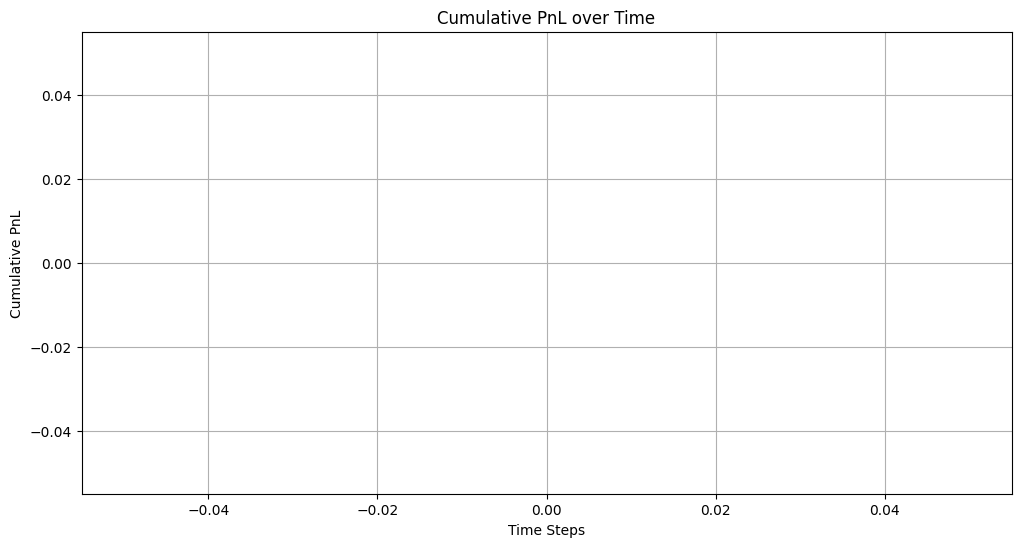

In [98]:
notional = 4000
holdings = 0      # Quantity of asset held
entry_price = None  # Price at which the current position was entered
quantity = 0.15     # Fixed trade size
pnl = 0           # Total PnL
pnls = []         # List to track PnL over time
cum_pnls = []     # Cumulative PnL
cum_notionals = []  # Cumulative notional values
total_fees = 0    # Total transaction fees paid
fee = 0.001      # Transaction fee (0.05%)
verbose = True
horizon = 15
for timestep in range(start + input_window, end, 1):
    if timestep % horizon == 0 and timestep+horizon < len(orderbook_subset):

        input_data = orderbook_subset[timestep-input_window:timestep+horizon].copy()
        hist_lob = input_data.values
        data_x, data_y, current_midprice, future_midprice, current_bid_price, current_ask_price, future_bid, future_ask = prepare_data(input_data, lag=horizon, delay=delay)
        ts_dataset = TimeSeriesDataset(data_x, data_y)
        test_loader = DataLoader(ts_dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0)

        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            # Get signals from models
            signals = []
            for model in models:
                signals.append(model(src.float()).detach().cpu().numpy()[0])
            current_signals = signals
            # Determine consensus signal
            positive_signals = sum(s > 0 for s in current_signals)
            negative_signals = sum(s < 0 for s in current_signals)

            # Open or Close Positions Based on Consensus
            if holdings == 0:
                if positive_signals == len(current_signals):
                    # Open Long Position
                    holdings += quantity
                    notional -= current_ask_price * quantity
                    notional -= current_ask_price * quantity * fee
                    entry_price = current_ask_price
                    total_fees += current_ask_price * quantity * fee
                    if verbose:
                        print(f"Long: quantity {quantity}, ask price {current_ask_price:.2f}, holdings {holdings}")
                elif negative_signals == len(current_signals):
                    # Open Short Position
                    holdings -= quantity
                    notional += current_bid_price * quantity
                    notional -= current_bid_price * quantity * fee
                    entry_price = current_bid_price
                    total_fees += current_bid_price * quantity * fee
                    if verbose:
                        print(f"Short: quantity {quantity}, bid price {current_bid_price:.2f}, holdings {holdings}")
            elif holdings > 0:
                # Close Long Position
                trade_pnl = (current_ask_price - entry_price) * quantity
                pnl += trade_pnl
                notional += current_ask_price * quantity
                notional -= current_ask_price * quantity * fee
                total_fees += (entry_price + current_ask_price) * quantity * fee
                holdings = 0
                entry_price = None
                if verbose:
                    print(f"Closing position: Long, PnL: {trade_pnl:.2f}, Holdings: {holdings}")
            elif holdings < 0:
                # Close Short Position
                trade_pnl = (entry_price - current_bid_price) * quantity
                pnl += trade_pnl
                notional += current_bid_price * quantity
                notional -= current_bid_price * quantity * fee
                total_fees += (entry_price + current_bid_price) * quantity * fee
                holdings = 0
                entry_price = None
                if verbose:
                    print(f"Closing position: Short, PnL: {trade_pnl:.2f}, Holdings: {holdings}")

        cum_notionals.append(notional)

    # Periodic Logging
    if timestep % 700 == 0 and not verbose:
        total_pnl = pnl
        print(f"Timestep: {timestep}, Notional: {notional:.2f}, PnL: {total_pnl:.2f}, Holdings: {holdings:.6f}")

# Plot Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cum_pnls)
plt.title('Cumulative PnL over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()

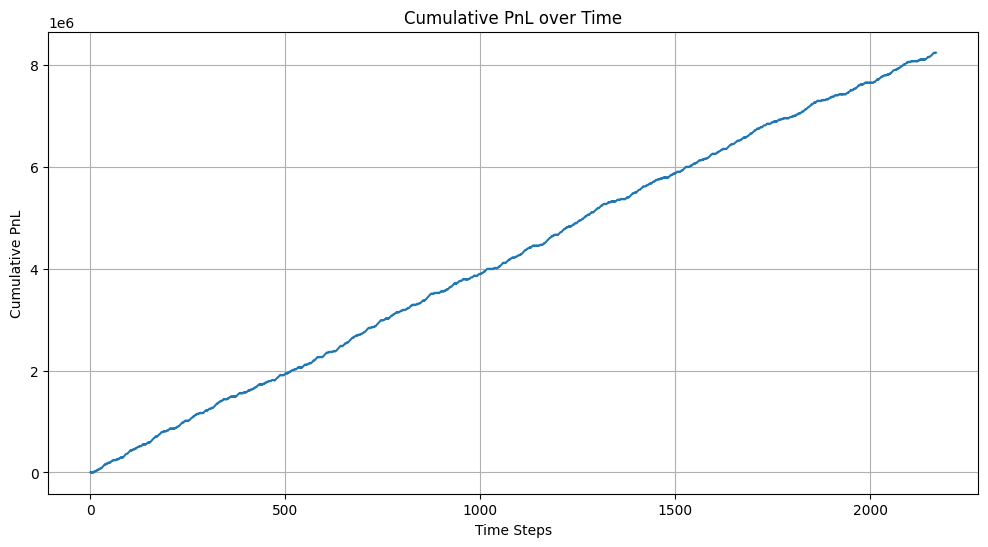

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(cum_notionals)
plt.title('Cumulative PnL over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.show()